## SSD Demo -- Noisy Detector

In [122]:
!ln -s /datasets/ee285f-public/nntools.py .

ln: failed to create symbolic link './nntools.py': File exists


In [478]:
%matplotlib inline
import os
import os.path as osp
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import math

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch.backends.cudnn as cudnn
import cv2
import ssd
from ssd import build_ssd
import random
from matplotlib import pyplot as plt
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform

from data import VOC_CLASSES as labels
import pickle as pkl

In [170]:
if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

In [171]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [172]:
VOC_ROOT='//datasets/ee285f-public/PascalVOC2012/'

In [173]:
testset = VOCDetection(VOC_ROOT, [('2012', 'val')], None, VOCAnnotationTransform())

### LOAD SSD NET

In [174]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('ssd300_mAP_77.43_v2.pth')

Loading weights...
Finished!


### LOAD DUDnCNN NET

In [175]:
class NNRegressor(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()
        
    def criterion(self, y, d):
        return self.mse(y, d)

In [185]:
class DUDnCNN(NNRegressor):
    
    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        
        self.conv.append(nn.Conv2d(3, C, 3, padding=1)) # Padding = (3-1)/2 ==> 1
        
        for k in range(D):
            if (k == D/2):
                l = 1
            elif(k > D/2):
                l += 2
            else:
                l = 0
            
            dil = int(1 + 2**(k-l) -1)
            self.conv.append(nn.Conv2d(C, C, 3, padding=dil, dilation=dil))
        
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C, C))
    
        for k in range(len(self.conv)-1):
            self.conv[k].weight.data = nn.init.kaiming_normal_(self.conv[k].weight.data, nonlinearity='relu')
        
        for k in range(D):    
            self.bn[k].weight.data = nn.init.constant_(self.bn[k].weight.data, 1.25 * np.sqrt(C))
        
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for k in range(D):
            torch.backends.cudnn.benchmark=True  # Q20 
            h = self.conv[k+1](h)
            torch.backends.cudnn.benchmark=False  # Q20
            h = F.relu(self.bn[k](h))
        
        y = self.conv[D+1](h) + x
        return y

In [186]:
net_DUDnCNN = torch.load('../Assignment_4_FINAL/denNet.pt')

In [307]:
impath = VOC_ROOT + "JPEGImages/" + random.choice(os.listdir(VOC_ROOT + "JPEGImages/"))
print(impath)

//datasets/ee285f-public/PascalVOC2012/JPEGImages/2012_000863.jpg


GOOD ONES:<br>
2011_000467.jpg<br>
2008_002243.jpg

In [308]:
def readImage(path, noisy=False, plot=False, noiseChar=(0,1,0.2)):
    orig = cv2.imread(impath, cv2.IMREAD_COLOR)
    rgb_image = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    orig_shape = orig.shape
    noisy_image = None
    
    loc = noiseChar[0]
    scale = noiseChar[1]
    strength = noiseChar[2]
    
    if noisy:
        noisy_orig = orig[...,::-1]/255.0 #normalization 
        noise =  np.random.normal(loc=loc, scale=scale, size=noisy_orig.shape) #random sampling 

        # noise overlaid over image
        nois = np.clip((noisy_orig + noise*strength),0,1)
        orig = nois*255.0
        noisy_image = orig
        
    x = cv2.resize(orig, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)

    if plot:
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.imshow(rgb_image)
        plt.subplot(122)
        plt.imshow((x*255).astype(np.uint8))

    if noisy:
        return x, rgb_image, noisy_image, noise*strength
    else:
        return x, rgb_image, noisy_image, None

### Detect Original

In [309]:
x, rgb_image, noisy_image, noise_overlay = readImage(impath, noisy=False, plot=False)

In [310]:
img = x.unsqueeze(0)
if torch.cuda.is_available():
    img = img.cuda()
y = net(img)

<Figure size 720x720 with 0 Axes>

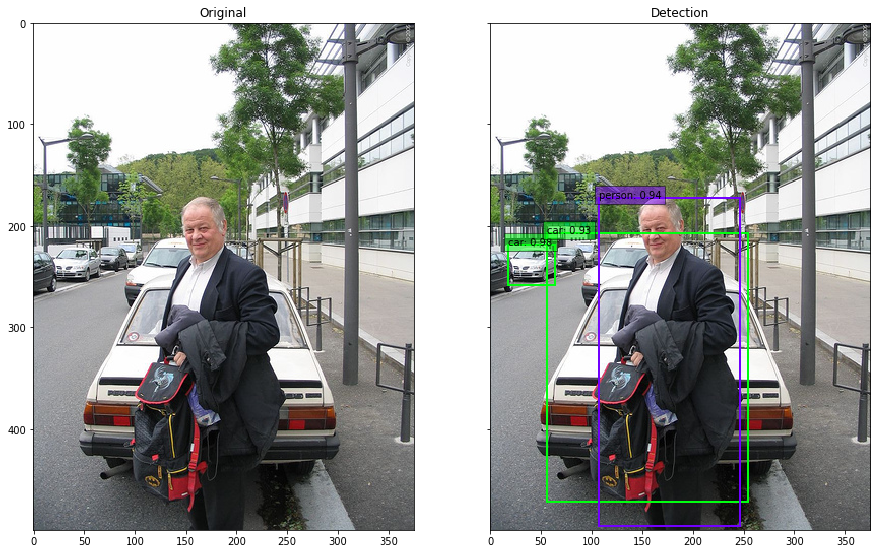

In [311]:
top_k=10
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
fig, axes = plt.subplots(1,2,sharex='all',sharey='all',figsize=(15,15))
    
axes[0].set_title('Original')    
axes[0].imshow(rgb_image)
axes[1].set_title('Detection')
axes[1].imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

**Experiment Parameters**

Mean = [-2, -1, 0, 1, 2]<br>
Standard Deviation = [1, 1.5, 2, 2.5, 3]<br>
Strength = [0.2, 0.4, 0.6, 0.8, 1]<br>

In [342]:
def noiseNorms(noisy_overlay):
    
    params = dict()
    RGB_flat = noise_overlay.reshape(-1,3)
    full_flat = RGB_flat.reshape(-1)
    
    params["R"] = np.linalg.norm(RGB_flat[:,0])
    params["G"] = np.linalg.norm(RGB_flat[:,1])
    params["B"] = np.linalg.norm(RGB_flat[:,2])
    params["Flat"] = np.linalg.norm(full_flat)    
    
    return params

In [343]:
NOISE_PARAMS = {}
NOISY_IMAGES = []
DENOISED_IMAGES = []

### Detect Noisy

In [469]:
# noisC = (mean, standard deviation, strength) of noise
noisC=(0, 1, 1.0)

x, rgb_image, noisy_image, noise_overlay = readImage(impath, noisy=True, plot=False, noiseChar=noisC)

NOISE_PARAMS[str(noisC)] = noiseNorms(noise_overlay)

In [470]:
img = x.unsqueeze(0)     # wrap tensor in Variable
if torch.cuda.is_available():
    img = img.cuda()
y = net(img)

<Figure size 504x504 with 0 Axes>

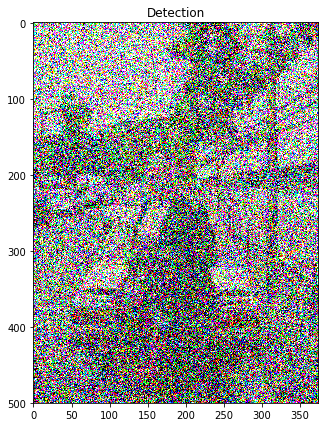

In [471]:
top_k=10

plt.figure(figsize=(7,7))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

fig, axes = plt.subplots(1,1,sharex='all',sharey='all',figsize=(7,7))
    
# axes[0].set_title('Noisy')    
# axes[0].imshow(noisy_image/255)
axes.set_title('Detection')
axes.imshow(noisy_image/255)  # plot the image for matplotlib

currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1
        
plt.savefig("images_out/noise_" +str(noisC)+ ".jpg")

### Detect Denoised 

In [472]:
x, rgb_image, noisy_image, noise_overlay = readImage(impath, noisy=True, plot=False, noiseChar=noisC)

In [473]:
def getDenoised(noisy_image, net_DUDnCNN):
    denoised = noisy_image
    im = Image.fromarray(np.uint8(denoised))
    image_size = (300,300)

    # declare a tranform to convert the image to a tensor and normalize it between [-1, 1]
    transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                                tv.transforms.ToTensor(), tv.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) 
    
    denoised = transform(im).unsqueeze(0)
    y = (net_DUDnCNN.forward(denoised)).detach()
    denoised = y[0].permute(1,2,0).numpy()
    denoised = 255.0*((denoised+1)/2)
    
    im2 = Image.fromarray(np.uint8(denoised))
    tran = tv.transforms.Compose([tv.transforms.Resize((rgb_image.shape[0],rgb_image.shape[1])), tv.transforms.ToTensor()])
    denoised = tran(im2)
    denoised = (tran(im2)*255.0).permute(1,2,0).numpy()

    x = cv2.resize(denoised, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)
    
    return x, denoised

In [474]:
x, denoised_image = getDenoised(noisy_image, net_DUDnCNN)

In [475]:
img = x.unsqueeze(0)
if torch.cuda.is_available():
    img = img.cuda()
y = net(img)

<Figure size 720x720 with 0 Axes>

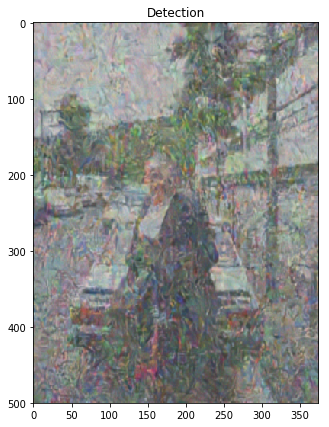

In [476]:
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

fig, axes = plt.subplots(1,1,sharex='all',sharey='all',figsize=(7,7))
 
# axes[0].set_title('Denoised')    
# axes[0].imshow(denoised_image/255)
axes.set_title('Detection')
axes.imshow(denoised_image/255)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1
        
plt.savefig("images_out/denoise_" +str(noisC)+ ".jpg")

In [479]:
with open('NOISE_PARAMS.pkl','wb') as f:
    pkl.dump(NOISE_PARAMS, f)

In [498]:
NOISE_PARAMS

{'(0, 1.5, 0.2)': {'R': 130.1190491537733,
  'G': 130.28354308856186,
  'B': 130.1330762376641,
  'Flat': 225.47591020654272},
 '(0, 1, 1)': {'R': 433.11062897413706,
  'G': 432.88254743240014,
  'B': 432.81899504827106,
  'Flat': 749.8695881795261},
 '(0, 1, 0.5)': {'R': 216.4612758924642,
  'G': 216.75345796245617,
  'B': 215.7282192369757,
  'Flat': 374.66813325239235},
 '(0, 1, 0.1)': {'R': 43.34589087469133,
  'G': 43.310797627534804,
  'B': 43.30417456051837,
  'Flat': 75.03294597189804},
 '(-2, 1, 0.2)': {'R': 193.80186685529335,
  'G': 193.80022381393772,
  'B': 193.6337765892031,
  'Flat': 335.57671221812546},
 '(-1, 1, 0.2)': {'R': 122.54403661791834,
  'G': 122.61022918136474,
  'B': 122.21059655664558,
  'Flat': 212.0984184789026},
 '(0, 1, 0.2)': {'R': 86.5336068665855,
  'G': 86.76480019830419,
  'B': 86.38010371964864,
  'Flat': 149.92570823381052},
 '(1, 1, 0.2)': {'R': 122.66957134873365,
  'G': 122.55147377747488,
  'B': 122.36845170966238,
  'Flat': 212.2280034155086